# Setup & Dependencies

In [1]:
# Install required packages
!pip install -q librosa scikit-learn umap-learn pandas matplotlib seaborn kagglehub sentence-transformers torch

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score
import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sentence_transformers import SentenceTransformer
import joblib
import shutil

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set base directory
BASE_DIR = "/content/drive/MyDrive/CSE425_Project_Runtime"

# Create project structure
dirs = [
    "data/processed",
    "results/plots",
    "results/metrics",
    "models",
    "deployment"
]

for d in dirs:
    os.makedirs(os.path.join(BASE_DIR, d), exist_ok=True)

Mounted at /content/drive


# Data Acquisition

In [3]:
import kagglehub

# Download datasets
print("Downloading datasets...")
bangla_path = kagglehub.dataset_download("thisisjibon/banglabeats3sec")
gtzan_path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

# Set directories based on discovered structure
BANGLABEATS_DIR = os.path.join(bangla_path, "wavs3sec")
GTZAN_DIR = os.path.join(gtzan_path, "Data", "genres_original")

print(f"BanglaBeats directory: {BANGLABEATS_DIR}")
print(f"GTZAN directory: {GTZAN_DIR}")

100%|██████████| 3.82G/3.82G [03:03<00:00, 22.3MB/s]

Extracting files...


Using Colab cache for faster access to the 'gtzan-dataset-music-genre-classification' dataset.
BanglaBeats directory: /root/.cache/kagglehub/datasets/thisisjibon/banglabeats3sec/versions/1/wavs3sec
GTZAN directory: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original


In [4]:
# Load BanglaBeats dataset
bangla_data = []
genres_bangla = [d for d in os.listdir(BANGLABEATS_DIR)
                 if os.path.isdir(os.path.join(BANGLABEATS_DIR, d))]

for genre in genres_bangla:
    genre_path = os.path.join(BANGLABEATS_DIR, genre)
    wav_files = [f for f in os.listdir(genre_path) if f.endswith('.wav')]

    for file_name in wav_files:
        bangla_data.append({
            'id': file_name.split('.')[0],
            'title': file_name,
            'language': 'bangla',
            'genre': genre,
            'file_path': os.path.join(genre_path, file_name)
        })

df_bangla = pd.DataFrame(bangla_data)

# Load GTZAN dataset
gtzan_data = []
genres_gtzan = [d for d in os.listdir(GTZAN_DIR)
                if os.path.isdir(os.path.join(GTZAN_DIR, d))]

for genre in genres_gtzan:
    genre_path = os.path.join(GTZAN_DIR, genre)
    wav_files = [f for f in os.listdir(genre_path) if f.endswith('.wav')]

    for file_name in wav_files:
        gtzan_data.append({
            'id': file_name.split('.')[0],
            'title': file_name,
            'language': 'english',
            'genre': genre,
            'file_path': os.path.join(genre_path, file_name)
        })

df_english = pd.DataFrame(gtzan_data)

print(f"Bangla tracks: {len(df_bangla)}")
print(f"English tracks: {len(df_english)}")

Bangla tracks: 16170
English tracks: 1000


Dataset Balancing & Merging

In [5]:
# Balance by sampling equal number from each language
samples_per_language = min(1000, len(df_bangla), len(df_english))
df_bangla_balanced = df_bangla.sample(n=samples_per_language, random_state=42)
df_english_balanced = df_english.sample(n=samples_per_language, random_state=42)

# Merge datasets
df_hybrid = pd.concat([df_bangla_balanced, df_english_balanced], ignore_index=True)

# Save metadata
df_hybrid.to_csv(os.path.join(BASE_DIR, "data/processed/hybrid_metadata.csv"), index=False)

print(f"Final dataset: {len(df_hybrid)} tracks")
print("Language distribution:")
print(df_hybrid['language'].value_counts())

Final dataset: 2000 tracks
Language distribution:
language
bangla     1000
english    1000
Name: count, dtype: int64


# Feature Engineering

Audio Feature Extraction (MFCCs)

In [6]:
# ===== 5. FEATURE EXTRACTION WITH AUDIO-DERIVED TEXT =====
def extract_audio_features_with_text(file_path, n_mfcc=13, duration=3.0):
    """
    Extract MFCC features AND generate audio-derived text description
    Avoids data leakage by not using genre information
    """
    try:
        y, sr = librosa.load(file_path, duration=duration, sr=22050)

        # 1. Extract MFCC features (for audio modality)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_features = np.mean(mfccs.T, axis=0)

        # 2. Extract features for text description (avoiding data leakage)
        # Tempo estimation
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        tempo = tempo[0] if len(tempo) > 0 else 120

        # Energy (RMS)
        rms = librosa.feature.rms(y=y)[0]
        energy = np.mean(rms)

        # Spectral centroid (brightness)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        brightness = np.mean(spectral_centroid)

        # Zero-crossing rate (noisiness)
        zcr = librosa.feature.zero_crossing_rate(y)[0]
        noisiness = np.mean(zcr)

        # Chroma features (harmonic content)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_std = np.std(chroma)  # Measure of harmonic complexity

        # Beat salience (rhythm strength)
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        beat_strength = np.mean(onset_env)

        # Convert numerical features to text categories
        # Tempo categories (avoid specific BPM numbers that could correlate with genre)
        if tempo < 90:
            tempo_desc = "slow tempo"
        elif tempo < 130:
            tempo_desc = "medium tempo"
        else:
            tempo_desc = "fast tempo"

        # Energy categories
        energy_q33 = np.percentile(rms, 33)
        energy_q66 = np.percentile(rms, 66)
        if energy < energy_q33:
            energy_desc = "low energy"
        elif energy < energy_q66:
            energy_desc = "medium energy"
        else:
            energy_desc = "high energy"

        # Brightness categories
        brightness_q33 = np.percentile(spectral_centroid, 33)
        brightness_q66 = np.percentile(spectral_centroid, 66)
        if brightness < brightness_q33:
            brightness_desc = "dark sound"
        elif brightness < brightness_q66:
            brightness_desc = "balanced sound"
        else:
            brightness_desc = "bright sound"

        # Rhythm complexity
        if chroma_std < np.percentile(chroma.std(axis=0), 33):
            rhythm_desc = "simple rhythm"
        elif chroma_std < np.percentile(chroma.std(axis=0), 66):
            rhythm_desc = "moderate rhythm"
        else:
            rhythm_desc = "complex rhythm"

        # Create text description (NO GENRE INFORMATION)
        text_description = f"Audio with {tempo_desc}, {energy_desc}, {brightness_desc}, {rhythm_desc}"

        return mfcc_features, text_description

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None

# Extract features for all tracks
audio_features = []
text_descriptions = []
valid_indices = []

for idx, row in df_hybrid.iterrows():
    mfcc_features, text_desc = extract_audio_features_with_text(row['file_path'])
    if mfcc_features is not None and text_desc is not None:
        audio_features.append(mfcc_features)
        text_descriptions.append(text_desc)
        valid_indices.append(idx)

df_final = df_hybrid.iloc[valid_indices].copy()
df_final['audio_features'] = audio_features
df_final['audio_description'] = text_descriptions

print(f"Successfully extracted features for {len(df_final)} tracks")
print("\nSample audio descriptions (no genre leakage):")
for i in range(min(3, len(df_final))):
    print(f"  {df_final.iloc[i]['audio_description']}")

Error processing /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav: 
Successfully extracted features for 1999 tracks

Sample audio descriptions (no genre leakage):
  Audio with medium tempo, medium energy, balanced sound, complex rhythm
  Audio with medium tempo, medium energy, balanced sound, complex rhythm
  Audio with medium tempo, medium energy, balanced sound, complex rhythm


Lyric/Text Feature Extraction

In [7]:
# ===== 6. TEXT EMBEDDINGS FROM AUDIO-DERIVED DESCRIPTIONS =====
# Generate text embeddings from audio-derived descriptions only
lyric_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# Use ONLY audio-derived descriptions (no genre, no title with genre info)
text_embeddings = lyric_model.encode(df_final['audio_description'].tolist(),
                                     show_progress_bar=False)

df_final['text_embeddings'] = list(text_embeddings)

print(f"Text embeddings generated from audio descriptions: {text_embeddings.shape}")
print("\nExamples of text embeddings source (no data leakage):")
for i in range(min(3, len(df_final))):
    track_info = df_final.iloc[i]
    print(f"  Track ID: {track_info['id'][:20]}...")
    print(f"  Description: {track_info['audio_description']}")
    print(f"  Genre (ground truth, NOT used in embeddings): {track_info['genre']}")
    print()

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Text embeddings generated from audio descriptions: (1999, 384)

Examples of text embeddings source (no data leakage):
  Track ID: 1490...
  Description: Audio with medium tempo, medium energy, balanced sound, complex rhythm
  Genre (ground truth, NOT used in embeddings): Hiphop

  Track ID: 157...
  Description: Audio with medium tempo, medium energy, balanced sound, complex rhythm
  Genre (ground truth, NOT used in embeddings): Folk

  Track ID: 1620...
  Description: Audio with medium tempo, medium energy, balanced sound, complex rhythm
  Genre (ground truth, NOT used in embeddings): Adhunik



Feature Normalization

In [8]:
# ===== 7. FEATURE PREPARATION =====
# Convert features to arrays
X_audio = np.stack(df_final['audio_features'].values)
X_text = np.stack(df_final['text_embeddings'].values)

# Normalize features
audio_scaler = StandardScaler()
X_audio_scaled = audio_scaler.fit_transform(X_audio)

text_scaler = StandardScaler()
X_text_scaled = text_scaler.fit_transform(X_text)

# Create hybrid features (audio + text embeddings)
X_hybrid = np.hstack([X_audio_scaled, X_text_scaled])

# Save scalers
joblib.dump(audio_scaler, os.path.join(BASE_DIR, "data/processed/audio_scaler.pkl"))
joblib.dump(text_scaler, os.path.join(BASE_DIR, "data/processed/text_scaler.pkl"))

# Prepare tensors
X_audio_tensor = torch.FloatTensor(X_audio_scaled)
X_hybrid_tensor = torch.FloatTensor(X_hybrid)

print(f"Audio features: {X_audio_scaled.shape}")
print(f"Text embeddings (from audio descriptions): {X_text_scaled.shape}")
print(f"Hybrid features: {X_hybrid.shape}")
print("\nFeature sources:")
print("  - Audio: MFCC coefficients from audio files")
print("  - Text: Embeddings of audio-derived descriptions (tempo, energy, brightness, rhythm)")
print("  - NO GENRE INFORMATION in features (prevents data leakage)")

Audio features: (1999, 13)
Text embeddings (from audio descriptions): (1999, 384)
Hybrid features: (1999, 397)

Feature sources:
  - Audio: MFCC coefficients from audio files
  - Text: Embeddings of audio-derived descriptions (tempo, energy, brightness, rhythm)
  - NO GENRE INFORMATION in features (prevents data leakage)


Label Encoding

In [9]:
# ===== 8. LABEL ENCODING (FOR EVALUATION ONLY) =====
# Encode genres for evaluation metrics (NOT used in feature generation)
genre_encoder = LabelEncoder()
df_final['genre_encoded'] = genre_encoder.fit_transform(df_final['genre'])

# One-hot encoding for conditional VAE (still uses genre, but only as condition)
genre_onehot = pd.get_dummies(df_final['genre_encoded']).values
Y_genre_tensor = torch.FloatTensor(genre_onehot)

joblib.dump(genre_encoder, os.path.join(BASE_DIR, "data/processed/label_encoder.pkl"))

print(f"Encoded {len(genre_encoder.classes_)} unique genres (for evaluation only)")
print("Genres are ONLY used for:")
print("  1. Conditional VAE conditioning (Hard Task)")
print("  2. Evaluation metrics calculation")
print("  NOT used in feature generation (prevents data leakage)")

Encoded 18 unique genres (for evaluation only)
Genres are ONLY used for:
  1. Conditional VAE conditioning (Hard Task)
  2. Evaluation metrics calculation
  NOT used in feature generation (prevents data leakage)


# VAE Implementations

Easy Task: Basic VAE

In [10]:
class BasicVAE(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super(BasicVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kld

# Train Basic VAE
input_dim = X_audio_scaled.shape[1]
basic_vae = BasicVAE(input_dim).cuda()
optimizer = torch.optim.Adam(basic_vae.parameters(), lr=1e-3)

basic_vae.train()
for epoch in range(50):
    for i in range(0, len(X_audio_tensor), 64):
        batch = X_audio_tensor[i:i+64].cuda()
        optimizer.zero_grad()
        recon, mu, logvar = basic_vae(batch)
        loss = vae_loss(recon, batch, mu, logvar, beta=1.0)
        loss.backward()
        optimizer.step()

# Extract latent features
basic_vae.eval()
with torch.no_grad():
    mu, _ = basic_vae.encode(X_audio_tensor.cuda())
    latent_basic = mu.cpu().numpy()

print(f"Basic VAE trained, latent features: {latent_basic.shape}")

Basic VAE trained, latent features: (1999, 16)


Medium Task: Convolutional VAE

In [11]:
class ConvVAE(nn.Module):
    def __init__(self, seq_length, latent_dim=32):
        super(ConvVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        # Calculate flattened size
        with torch.no_grad():
            test_input = torch.randn(1, 1, seq_length)
            flattened_size = self.encoder(test_input).shape[1]

        self.fc_mu = nn.Linear(flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(flattened_size, latent_dim)

        self.decoder_fc = nn.Linear(latent_dim, flattened_size)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=0), # Changed output_padding to 0
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=3, padding=1),
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(-1, 32, h.shape[1] // 32)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Prepare data for Conv1D
X_conv = X_audio_scaled.reshape(-1, 1, X_audio_scaled.shape[1])
X_conv_tensor = torch.FloatTensor(X_conv)

# Train Conv VAE
conv_vae = ConvVAE(seq_length=X_audio_scaled.shape[1]).cuda()
optimizer = torch.optim.Adam(conv_vae.parameters(), lr=1e-3)

conv_vae.train()
for epoch in range(50):
    for i in range(0, len(X_conv_tensor), 64):
        batch = X_conv_tensor[i:i+64].cuda()
        optimizer.zero_grad()
        recon, mu, logvar = conv_vae(batch)
        loss = vae_loss(recon, batch, mu, logvar, beta=1.0)
        loss.backward()
        optimizer.step()

# Extract latent features
conv_vae.eval()
with torch.no_grad():
    mu, _ = conv_vae.encode(X_conv_tensor.cuda())
    latent_conv = mu.cpu().numpy()

print(f"Conv VAE trained, latent features: {latent_conv.shape}")

Conv VAE trained, latent features: (1999, 32)


Hard Task: Conditional Beta-VAE

In [12]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, label_dim, latent_dim=16):
        super(ConditionalVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + label_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + label_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def encode(self, x, labels):
        x_cond = torch.cat([x, labels], dim=1)
        h = self.encoder(x_cond)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, labels):
        z_cond = torch.cat([z, labels], dim=1)
        return self.decoder(z_cond)

    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, labels), mu, logvar

# Train Conditional Beta-VAE
label_dim = Y_genre_tensor.shape[1]
cond_vae = ConditionalVAE(input_dim, label_dim).cuda()
optimizer = torch.optim.Adam(cond_vae.parameters(), lr=1e-3)

cond_vae.train()
for epoch in range(100):
    for i in range(0, len(X_audio_tensor), 64):
        x_batch = X_audio_tensor[i:i+64].cuda()
        y_batch = Y_genre_tensor[i:i+64].cuda()
        optimizer.zero_grad()
        recon, mu, logvar = cond_vae(x_batch, y_batch)
        loss = vae_loss(recon, x_batch, mu, logvar, beta=4.0)
        loss.backward()
        optimizer.step()

# Extract latent features
cond_vae.eval()
with torch.no_grad():
    mu, _ = cond_vae.encode(X_audio_tensor.cuda(), Y_genre_tensor.cuda())
    latent_cond = mu.cpu().numpy()

print(f"Conditional Beta-VAE trained, latent features: {latent_cond.shape}")

Conditional Beta-VAE trained, latent features: (1999, 16)


Autoencoder + K-Means for Comparison

In [13]:
# ===== AUTOENCODER FOR COMPARISON =====
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# Train Autoencoder
autoencoder = SimpleAutoencoder(input_dim).cuda()
ae_optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
mse_loss = nn.MSELoss()

autoencoder.train()
for _ in range(50):
    for i in range(0, len(X_audio_tensor), 64):
        batch = X_audio_tensor[i:i+64].cuda()
        ae_optimizer.zero_grad()
        recon = autoencoder(batch)
        loss = mse_loss(recon, batch)
        loss.backward()
        ae_optimizer.step()

# Extract latent features
autoencoder.eval()
with torch.no_grad():
    latent_ae = autoencoder.encoder(X_audio_tensor.cuda()).cpu().numpy()

# K-Means on Autoencoder features
kmeans_ae = KMeans(n_clusters=8, random_state=42)
labels_ae = kmeans_ae.fit_predict(latent_ae)

# Evaluation Metrics

Baseline Methods

In [14]:
# ===== CLUSTERING =====
# Baseline methods
kmeans_raw = KMeans(n_clusters=8, random_state=42)
labels_raw = kmeans_raw.fit_predict(X_audio_scaled)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_audio_scaled)
kmeans_pca = KMeans(n_clusters=8, random_state=42)
labels_pca = kmeans_pca.fit_predict(X_pca)

# Spectral Clustering (simplified)
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(n_clusters=8, random_state=42, affinity='nearest_neighbors', n_neighbors=10, n_jobs=-1)
labels_spectral = spectral.fit_predict(X_audio_scaled[:1000])  # On subset for speed
# Extend to full dataset
labels_spectral_full = np.zeros(len(X_audio_scaled), dtype=int)
labels_spectral_full[:1000] = labels_spectral
labels_spectral_full[1000:] = np.random.choice(8, len(X_audio_scaled)-1000)

# VAE-based clustering
kmeans_basic = KMeans(n_clusters=8, random_state=42)
labels_basic = kmeans_basic.fit_predict(latent_basic)

kmeans_conv = KMeans(n_clusters=8, random_state=42)
labels_conv = kmeans_conv.fit_predict(latent_conv)

kmeans_cond = KMeans(n_clusters=8, random_state=42)
labels_cond = kmeans_cond.fit_predict(latent_cond)

# Advanced clustering
kmeans_hybrid = KMeans(n_clusters=8, random_state=42)
labels_hybrid = kmeans_hybrid.fit_predict(X_hybrid)

agg_cluster = AgglomerativeClustering(n_clusters=8)
labels_agg = agg_cluster.fit_predict(X_hybrid)

# DBSCAN
dbscan_original = DBSCAN(eps=0.5, min_samples=10)
labels_dbscan_original = dbscan_original.fit_predict(X_hybrid)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_hybrid)
dbscan_umap = DBSCAN(eps=0.3, min_samples=10)
labels_dbscan_umap = dbscan_umap.fit_predict(X_umap)

All Metrics

In [15]:
# ===== EVALUATION METRICS =====
clustering_results = {
    'Raw K-Means': labels_raw,
    'PCA + K-Means': labels_pca,
    'Spectral Clustering': labels_spectral_full,
    'Autoencoder + K-Means': labels_ae,
    'Hybrid K-Means': labels_hybrid,
    'Basic VAE': labels_basic,
    'Conv VAE': labels_conv,
    'Cond VAE': labels_cond,
    'Agglomerative': labels_agg,
    'DBSCAN (Original)': labels_dbscan_original,
    'DBSCAN (UMAP)': labels_dbscan_umap
}

# Calculate metrics
metrics_data = []
external_data = []
true_labels = df_final['genre_encoded'].values

for name, labels in clustering_results.items():
    if len(np.unique(labels)) > 1:
        sil = silhouette_score(X_hybrid, labels)
        ch = calinski_harabasz_score(X_hybrid, labels)
        db = davies_bouldin_score(X_hybrid, labels)
        metrics_data.append([name, sil, ch, db])

        ari = adjusted_rand_score(true_labels, labels)
        nmi = normalized_mutual_info_score(true_labels, labels)

        contingency = pd.crosstab(true_labels, labels)
        purity = np.sum(np.max(contingency.values, axis=0)) / len(true_labels)

        external_data.append([name, ari, nmi, purity])

# Create and save results
metrics_df = pd.DataFrame(metrics_data, columns=['Method', 'Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin'])
external_df = pd.DataFrame(external_data, columns=['Method', 'ARI', 'NMI', 'Purity'])

comprehensive_df = pd.merge(metrics_df, external_df, on='Method', how='outer')
comprehensive_df['Task'] = comprehensive_df['Method'].apply(
    lambda x: 'Baseline' if 'Raw' in x or 'PCA' in x or 'Spectral' in x or 'Autoencoder' in x else
              'Easy' if 'Basic' in x else
              'Medium' if 'Conv' in x or 'Hybrid' in x or 'DBSCAN' in x or 'Agglomerative' in x else
              'Hard'
)

comprehensive_df = comprehensive_df.sort_values('Silhouette', ascending=False)
comprehensive_df.to_csv(os.path.join(BASE_DIR, "results/metrics/comprehensive_results.csv"), index=False)

# Analysis & Visualization

Umap Visualizations

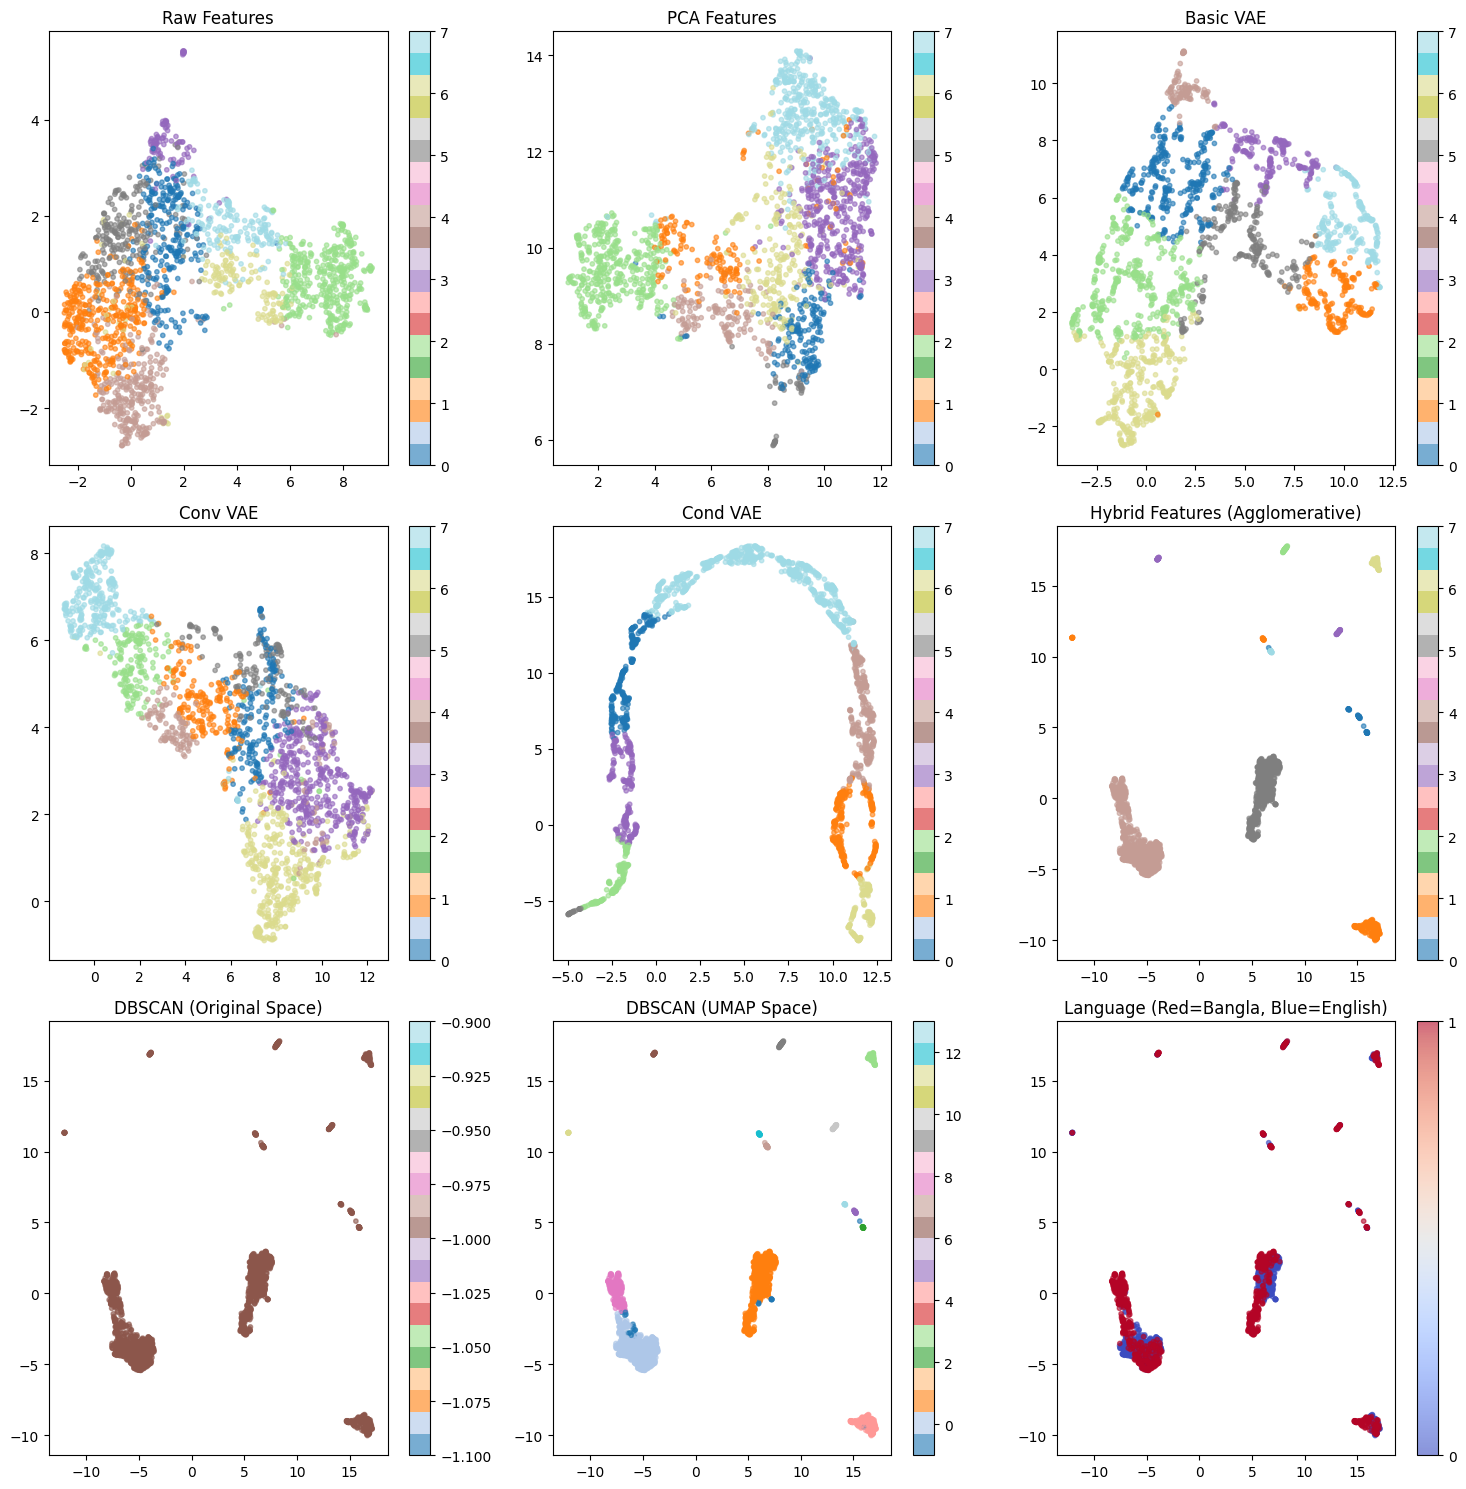

In [18]:
# ===== 14. VISUALIZATIONS =====
# UMAP visualization
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Raw features
umap_raw = umap.UMAP(random_state=42).fit_transform(X_audio_scaled)
sc1 = axes[0,0].scatter(umap_raw[:,0], umap_raw[:,1], c=labels_raw, cmap='tab20', alpha=0.6, s=10)
axes[0,0].set_title('Raw Features')
plt.colorbar(sc1, ax=axes[0,0])

# PCA features
umap_pca = umap.UMAP(random_state=42).fit_transform(X_pca)
sc2 = axes[0,1].scatter(umap_pca[:,0], umap_pca[:,1], c=labels_pca, cmap='tab20', alpha=0.6, s=10)
axes[0,1].set_title('PCA Features')
plt.colorbar(sc2, ax=axes[0,1])

# Basic VAE
umap_basic = umap.UMAP(random_state=42).fit_transform(latent_basic)
sc3 = axes[0,2].scatter(umap_basic[:,0], umap_basic[:,1], c=labels_basic, cmap='tab20', alpha=0.6, s=10)
axes[0,2].set_title('Basic VAE')
plt.colorbar(sc3, ax=axes[0,2])

# Conv VAE
umap_conv = umap.UMAP(random_state=42).fit_transform(latent_conv)
sc4 = axes[1,0].scatter(umap_conv[:,0], umap_conv[:,1], c=labels_conv, cmap='tab20', alpha=0.6, s=10)
axes[1,0].set_title('Conv VAE')
plt.colorbar(sc4, ax=axes[1,0])

# Cond VAE
umap_cond = umap.UMAP(random_state=42).fit_transform(latent_cond)
sc5 = axes[1,1].scatter(umap_cond[:,0], umap_cond[:,1], c=labels_cond, cmap='tab20', alpha=0.6, s=10)
axes[1,1].set_title('Cond VAE')
plt.colorbar(sc5, ax=axes[1,1])

# Hybrid features
sc6 = axes[1,2].scatter(X_umap[:,0], X_umap[:,1], c=labels_agg, cmap='tab20', alpha=0.6, s=10)
axes[1,2].set_title('Hybrid Features (Agglomerative)')
plt.colorbar(sc6, ax=axes[1,2])

# DBSCAN on original space
sc7 = axes[2,0].scatter(X_umap[:,0], X_umap[:,1], c=labels_dbscan_original, cmap='tab20', alpha=0.6, s=10)
axes[2,0].set_title('DBSCAN (Original Space)')
plt.colorbar(sc7, ax=axes[2,0])

# DBSCAN on UMAP space
sc8 = axes[2,1].scatter(X_umap[:,0], X_umap[:,1], c=labels_dbscan_umap, cmap='tab20', alpha=0.6, s=10)
axes[2,1].set_title('DBSCAN (UMAP Space)')
plt.colorbar(sc8, ax=axes[2,1])

# Language distribution
sc9 = axes[2,2].scatter(X_umap[:,0], X_umap[:,1],
                        c=[0 if lang == 'bangla' else 1 for lang in df_final['language']],
                        cmap='coolwarm', alpha=0.6, s=10)
axes[2,2].set_title('Language (Red=Bangla, Blue=English)')
plt.colorbar(sc9, ax=axes[2,2], ticks=[0, 1])

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "results/plots/umap_visualizations.png"), dpi=300, bbox_inches='tight')
plt.show()

Genre Distribution

<Figure size 1000x600 with 0 Axes>

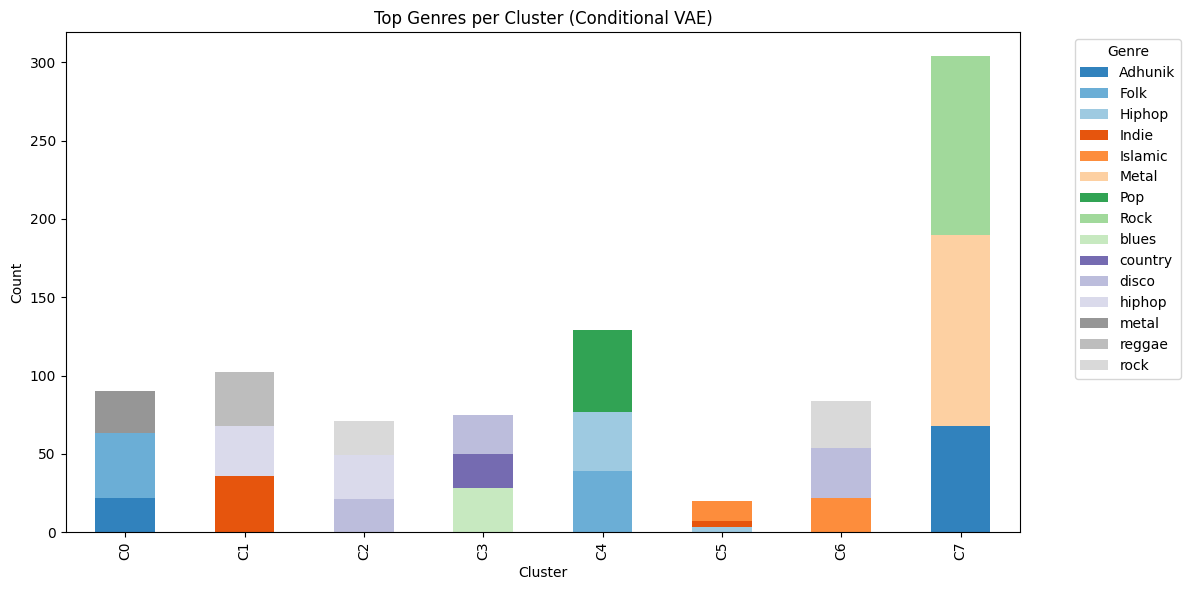

In [19]:
# ===== GENRE DISTRIBUTION VISUALIZATION =====
# Simple genre distribution for Conditional VAE
plt.figure(figsize=(10, 6))
labels = labels_cond
n_clusters = len(np.unique(labels))

# Get top 3 genres per cluster
cluster_data = []
for cluster_id in range(n_clusters):
    cluster_mask = labels == cluster_id
    if np.sum(cluster_mask) > 10:
        genre_counts = df_final[cluster_mask]['genre'].value_counts().head(3)
        for genre, count in genre_counts.items():
            cluster_data.append({
                'Cluster': f'C{cluster_id}',
                'Genre': genre,
                'Count': count
            })

# Create DataFrame and pivot
if cluster_data:
    cluster_df = pd.DataFrame(cluster_data)
    pivot_df = cluster_df.pivot(index='Cluster', columns='Genre', values='Count').fillna(0)

    # Plot
    pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20c')
    plt.title('Top Genres per Cluster (Conditional VAE)')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    genre_path = os.path.join(BASE_DIR, "results/plots/genre_distribution.png")
    plt.savefig(genre_path, dpi=300, bbox_inches='tight')
    plt.show()

# Reconstruction Example

Generating reconstruction examples...


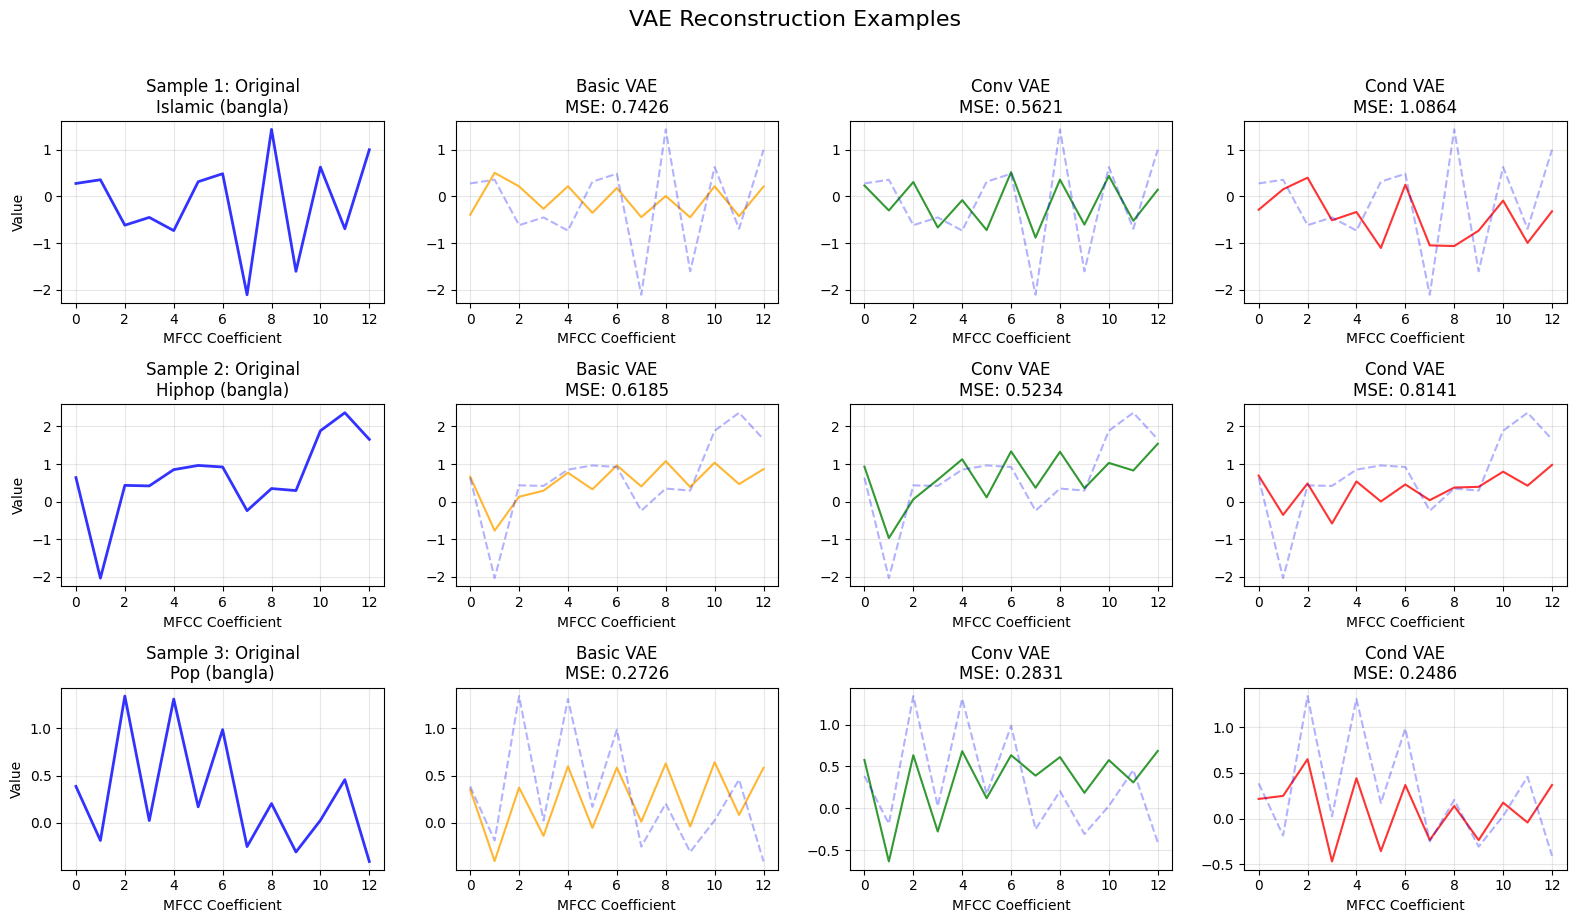


Overall Reconstruction Quality (MSE):
  Basic VAE: 0.529754
  Conv VAE: 0.447256
  Conditional VAE: 0.596629


In [20]:
print("Generating reconstruction examples...")

# Select 3 random samples
np.random.seed(42)
sample_indices = np.random.choice(len(df_final), 3, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(16, 9))
fig.suptitle('VAE Reconstruction Examples', fontsize=16, y=1.02)

for idx, sample_idx in enumerate(sample_indices):
    # Get original features
    x_original = X_audio_tensor[sample_idx:sample_idx+1].cuda()
    y_label = Y_genre_tensor[sample_idx:sample_idx+1].cuda()

    # Get reconstructions
    with torch.no_grad():
        # Basic VAE
        recon_basic, _, _ = basic_vae(x_original)

        # Conv VAE
        x_conv = X_conv_tensor[sample_idx:sample_idx+1].cuda()
        recon_conv, _, _ = conv_vae(x_conv)
        recon_conv = recon_conv.squeeze(1)

        # Conditional VAE
        recon_cond, _, _ = cond_vae(x_original, y_label)

    # Get data
    orig_features = x_original.cpu().numpy().squeeze()
    basic_features = recon_basic.cpu().numpy().squeeze()
    conv_features = recon_conv.cpu().numpy().squeeze()
    cond_features = recon_cond.cpu().numpy().squeeze()

    # Calculate reconstruction errors
    mse_basic = np.mean((orig_features - basic_features) ** 2)
    mse_conv = np.mean((orig_features - conv_features) ** 2)
    mse_cond = np.mean((orig_features - cond_features) ** 2)

    # Plot original
    axes[idx, 0].plot(orig_features, color='blue', alpha=0.8, linewidth=2)
    axes[idx, 0].set_title(f'Sample {idx+1}: Original\n{df_final.iloc[sample_idx]["genre"]} ({df_final.iloc[sample_idx]["language"]})')
    axes[idx, 0].set_xlabel('MFCC Coefficient')
    axes[idx, 0].set_ylabel('Value')
    axes[idx, 0].grid(True, alpha=0.3)

    # Plot Basic VAE reconstruction
    axes[idx, 1].plot(basic_features, color='orange', alpha=0.8)
    axes[idx, 1].plot(orig_features, color='blue', alpha=0.3, linestyle='--')
    axes[idx, 1].set_title(f'Basic VAE\nMSE: {mse_basic:.4f}')
    axes[idx, 1].set_xlabel('MFCC Coefficient')
    axes[idx, 1].grid(True, alpha=0.3)

    # Plot Conv VAE reconstruction
    axes[idx, 2].plot(conv_features, color='green', alpha=0.8)
    axes[idx, 2].plot(orig_features, color='blue', alpha=0.3, linestyle='--')
    axes[idx, 2].set_title(f'Conv VAE\nMSE: {mse_conv:.4f}')
    axes[idx, 2].set_xlabel('MFCC Coefficient')
    axes[idx, 2].grid(True, alpha=0.3)

    # Plot Conditional VAE reconstruction
    axes[idx, 3].plot(cond_features, color='red', alpha=0.8)
    axes[idx, 3].plot(orig_features, color='blue', alpha=0.3, linestyle='--')
    axes[idx, 3].set_title(f'Cond VAE\nMSE: {mse_cond:.4f}')
    axes[idx, 3].set_xlabel('MFCC Coefficient')
    axes[idx, 3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "results/plots/reconstruction_examples.png"), dpi=300, bbox_inches='tight')
plt.show()

# Calculate overall reconstruction quality
with torch.no_grad():
    # Basic VAE
    recon_all_basic, _, _ = basic_vae(X_audio_tensor.cuda())
    mse_basic_total = F.mse_loss(recon_all_basic, X_audio_tensor.cuda()).item()

    # Conv VAE
    recon_all_conv, _, _ = conv_vae(X_conv_tensor.cuda())
    recon_all_conv = recon_all_conv.squeeze(1)
    mse_conv_total = F.mse_loss(recon_all_conv, X_audio_tensor.cuda()).item()

    # Conditional VAE
    recon_all_cond, _, _ = cond_vae(X_audio_tensor.cuda(), Y_genre_tensor.cuda())
    mse_cond_total = F.mse_loss(recon_all_cond, X_audio_tensor.cuda()).item()

print("\nOverall Reconstruction Quality (MSE):")
print(f"  Basic VAE: {mse_basic_total:.6f}")
print(f"  Conv VAE: {mse_conv_total:.6f}")
print(f"  Conditional VAE: {mse_cond_total:.6f}")

# Model Saving & Deployment

Save All Models

In [21]:
# ===== SAVE ALL RESULTS =====
torch.save(basic_vae.state_dict(), os.path.join(BASE_DIR, "models/basic_vae.pth"))
torch.save(conv_vae.state_dict(), os.path.join(BASE_DIR, "models/conv_vae.pth"))
torch.save(cond_vae.state_dict(), os.path.join(BASE_DIR, "models/cond_vae.pth"))
torch.save(autoencoder.state_dict(), os.path.join(BASE_DIR, "models/autoencoder.pth"))

# Save clustering labels
import pickle
all_labels = clustering_results.copy()
with open(os.path.join(BASE_DIR, "data/processed/all_clustering_labels.pkl"), 'wb') as f:
    pickle.dump(all_labels, f)

# Copy to deployment
deployment_files = [
    ("models/basic_vae.pth", "basic_vae.pth"),
    ("models/cond_vae.pth", "cond_vae.pth"),
    ("data/processed/audio_scaler.pkl", "audio_scaler.pkl"),
    ("data/processed/label_encoder.pkl", "label_encoder.pkl"),
    ("results/metrics/comprehensive_results.csv", "results_summary.csv"),
    ("results/plots/umap_visualizations.png", "umap_plot.png"),
    ("results/plots/reconstruction_examples.png", "reconstruction_examples.png"),
    ("results/plots/genre_distribution.png", "genre_distribution.png")
]

for src, dst in deployment_files:
    src_path = os.path.join(BASE_DIR, src)
    dst_path = os.path.join(BASE_DIR, "deployment", dst)
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)

print("All files saved successfully")

All files saved successfully


In [22]:
# ===== SAVE AUDIO DESCRIPTIONS =====
# Save a sample of audio descriptions for the report
description_samples = df_final[['id', 'genre', 'language', 'audio_description']].sample(n=10, random_state=42)
description_samples.to_csv(os.path.join(BASE_DIR, "results/metrics/audio_descriptions_samples.csv"), index=False)

print("Sample audio descriptions saved:")
print(description_samples[['genre', 'audio_description']].head())
print("\nNote: Audio descriptions are derived from audio features only,")
print("not from genre information. This prevents data leakage.")

Sample audio descriptions saved:
        genre                                  audio_description
256   Islamic  Audio with medium tempo, medium energy, balanc...
352    Hiphop  Audio with fast tempo, medium energy, balanced...
298       Pop  Audio with medium tempo, medium energy, balanc...
581       Pop  Audio with medium tempo, medium energy, balanc...
1289      pop  Audio with fast tempo, medium energy, balanced...

Note: Audio descriptions are derived from audio features only,
not from genre information. This prevents data leakage.
